In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt

# Optimal Strategy for 2-Player Probabilistic Dart Game
**by Chayut Chunsamphran (6381250) as part of MUIC's ICCS205 Numerical Computation (ICPY334 Numerical Methods for Physics)**

## The Game

Inspired by [this Numberphile video](https://www.youtube.com/watch?v=6_yU9eJ0NxA), I decided to make my own version of the probabilistic dart game. The game is simple and played much like the dice game Pig. 

Each player takes turn to play the game. In each turn, the player will throw a dart at the dart board. If the player lands a shot, he can choose to **bank the score equal to the total number of throws landed**, or throw one more dart to potentially get a higher score for the turn. However, if at any point the player misses the board, all prior throws are ignored and he **gets the score of 0** for that turn. Basically, the player can either throw until he misses, or choose to stop before missing. Whoever hits the score of **10** first wins.

There is a catch, though. The player's throw is **randomly distributed around a unit circle centred at the origin**. The dart board starts off as the same unit circle (the first shot never misses), but for every throw landed, it shrinks according to the following rules:

- Draw a line $\overline{OH}$ connecting the centre of the board, $O$,  and the point where the dart lands, $H$.
- Perpendicular to $\overline{OH}$, draw a chord of the current board circle, $\overline{AB}$,  such that it passes through $H$.
- The new board is the circle with the same centre and the radius of $\frac{|\overline{AB}|}{2}$.

<img src="shrink.png" alt="shrink" width="350"/>


The player is rewarded from throwing a good shot (near the centre) by the fact that the board will not shrink much, and punished from throwing a bad shot (far from the centre) by the fact that the board will shrink a lot. The throw distribution remains the same on every throw, regardless of the board size, and the board resets after the player ends the turn (the player's game is unaffected by the opponent's).

## The Problem

We want to find the optimal strategy that yields the best chance to win for every situation. This is mathematically complicated for 2-player case, as the player's score, the other player's score, and the probability of landing a shot in that situation all affect the best strategy.

To do this, we will first have to find the probability of landing shots and the expected score for single-player. We will use the aim-for-score strategy which banks the turn immediately after hitting the target score. With this, the optimal strategy is an array of the best target scores given the player's and the opponent's cumulative score. The best target score will be found using value iteration, which computes the action to take on each state to maximises the future reward.

### Part 1: Simulating the Game

We are going to run a Monte Carlo simulation on the singleplayer version of this game, where the player plays until he misses, and the score he gets for that round is the number of darts thrown before missing. Once we get the frequencies of getting each score, we can use them to calculate further probabilities.

In [4]:
def in_sphere(point, radius):
    """Determine if a n-dimensional point is within the n-dimensional sphere of a given radius"""
    return sum([p**2 for p in point]) <= radius**2


def chord_halflen(point, original_radius):
    """
    Half the length of the chord of the original n-dimensional sphere perpendicular to the radius 
    line at a n-dimensional point
    """
    return np.sqrt(original_radius**2 - sum([p**2 for p in point]))


def random_point_2d():
    """Generate a uniformly random Cartesian point within a unit circle"""
    r = np.sqrt(np.random.random()) # sqrt so the distances between points are uniform
    theta = 2 * np.pi * np.random.random()
    return np.array([r*np.cos(theta), r*np.sin(theta)])


def dart_game(n_games, max_score, dimension=2):
    """
    Simulate the dart game and count the frequencies that each score is achieved.
    
    Variables
    ---------
    n_games: Number of games to simulate
    dimensions: Dimension of the dart board and random distribution (default: 2)
    max_score: Maximum score to count. Anything beyond will just be regarded as 'max_score and above'
    
    Returns
    ---------
    freq: An array of frequencies that the score of i is achieved for i = 1, 2, ..., max_score - 1, 
          and the frequency of getting max_score and above (as the last component)
    """
    freq = np.zeros(max_score)
    
    for _ in range(n_games):
        board_radius = 1
        turn_score = 0
        while True:
            point = random_point_2d()
            if in_sphere(point, board_radius):
                turn_score += 1
                board_radius = chord_halflen(point, board_radius)
            else:
                break
        if turn_score < max_score:
            freq[turn_score - 1] += 1
        else:
            freq[-1] += 1
    return freq


score_freq = dart_game(10000000, 10)
print(score_freq)


[5.000692e+06 3.333279e+06 1.250724e+06 3.321030e+05 6.927600e+04
 1.191300e+04 1.759000e+03 2.260000e+02 2.600000e+01 2.000000e+00]


### Part 2: Probabilities of Landing and Expected Score

Since we are going to do the value iteration, we need to know the probability of getting from one state to another state. In other words, we need to know the probability that, at the score $k$, the player will land the next throw:

$$
P_{k, land} = \sum_{i=k+1}^{\infty} P_{score=i} \tag{2.1} \label{2.1}
$$

and subsequently the probability that the player will miss the next throw, 

$$
P_{k, miss} = 1 - P_{k, land} \tag{2.2}
$$

The expected score for singleplayer version will be used as a baseline for further calculations:

$$
E = \sum_{i=1}^{\infty} i \cdot P_{score=i} \tag{2.3}
$$

In [5]:
def score_prob(score_freq):
    """Return an array of probabilities of getting each score given the score frequencies array"""
    n_data = sum(score_freq)
    return np.array([freq / n_data for freq in score_freq])


def landing_prob(score, probabilities):
    """Probability of landing the next throw at a given score from probabilities array"""
    return sum(probabilities[score:])


def expected_score(score_freq):
    """Expected singleplayer score given the score frequencies array"""
    n_data = sum(score_freq)
    total_score = 0
    for i in range(len(score_freq)):
        total_score += (i + 1) * score_freq[i]
    return total_score / n_data


# test
score_prob = score_prob(score_freq)
expected = expected_score(score_freq)
print("Probabilities of getting each score: ", score_prob)
print("Expected score: ", expected)
print("Probability of landing the next throw at score = 1: ", landing_prob(1, score_prob))

Probabilities of getting each score:  [5.000692e-01 3.333279e-01 1.250724e-01 3.321030e-02 6.927600e-03
 1.191300e-03 1.759000e-04 2.260000e-05 2.600000e-06 2.000000e-07]
Expected score:  1.7180067
Probability of landing the next throw at score = 1:  0.4999308


### Part 3: Value Iteration

Value iteration is the process that estimate the value of the current state of the game by iterating over and over. Here's briefly how it works.

The game consists of *states, actions*, and *rewards*. Consider the state of the game $\mathcal{s}$ when the player's score is $i$, the opponent's score is $j$, and the player's score in the current turn is $k$. In the case where $i, j < 10$ and $i + k < 10$, the optimal probability of winning for such state is:

$$
P_{i,j,k} = \max (P_{i,j,k,throw}, P_{i,j,k,bank}) \tag{3.1} \label{3.1}
$$

where $P_{i,j,k,action}$ is the probability of winning the overall game if the player choose to do an action. For our game, these are:

$$
P_{i,j,k,throw} = P_{k,miss}(1 - P_{j,i,0}) + P_{k,land} \cdot P_{i,j,k+1} \tag{3.2}
$$

$$
P_{i,j,k,bank} = 1 - P_{j,i+k,0} \tag{3.3}
$$

For every $\mathcal{s, s'}$ in a finite set of states $\mathcal{S}$, there is a probability $\mathcal{P^a_{ss'}}$ that an action $\mathcal{a \in A}$ will transition state $\mathcal{s}$ to state $\mathcal{s'}$. We assign value to these actions to determine what is good or bad by introducing immediate rewards $\mathcal{R^a_{ss'}}$ and future rewards $V(s')$. This means that the estimated value of a state $V(s)$ is the maximum value of its actions:

$$
V(s) = \max_a \sum_{s'} \mathcal{P^a_{ss'}} [\mathcal{R^a_{ss'}} + \gamma V(s')] \tag{3.4} \label{3.4}
$$

where $\gamma \in [0, 1]$ is the discount factor, which denotes how much we care about future rewards.

For our game, because we care about winning and not maximum expected turn score, we reward only winning with $\mathcal{R^a_{ss'}} = 1$, and if losing, $\mathcal{R^a_{ss'}} = 0$. Another unknown $V(s)$ can be realised by taking $\gamma = 1$. In this case, $V(s)$ is the same as the probability of transitioning from a non-winning state to a winning state, i.e., the probability of winning from state $s$, or $P_{i,j,k}$.

One may now see that, with these assumption, equation $\eqref{3.4}$ becomes the same as solving for $P_{i,j,k}$ in equation $\eqref{3.1}$. For each $s$ in decending order of $i+j$, we can iterate equation $\eqref{3.1}$ until it converges with some torelance $\varepsilon$ to solve for $P_{i,j,k}$. The symmetry of the game and the initial condition that $P_{i,j,k} = 1$ if $i + k \geq 10$ (because we can just bank and win) help optimise the process greatly.

In [6]:
def dartSolve(goal, score_probabilities, tolerance=1e-6):
    """
    Solve for optimal dart game using value iteration
    
    Variables
    ---------
    goal: Winning score
    score_probabilities: Array of probabilities of getting each turn score in singleplayer
    tolerance: Tolerance for value iteration
    
    Returns
    ---------
    p: 3D array of the probabilities of winning at state (i,j,k)
    throw: 3D array of the best action for state (i,j,k). True if throwing is better and False if banking is better.
    """
    epsilon = tolerance
    p = np.ones((goal, goal, goal))
    throw = np.empty((goal, goal, goal))
    
    def partition_2(a, goal):
        """Partition of a using 2 numbers not exceeding goal with permutation"""
        parts = []
        for i in range(a+1):
            if a-i < goal and i < goal:
                parts.append([i, a-i])
        return parts
        

    def pWin(i, j, k):
        """Probability of winning at state s(i,j,k)"""
        if i + k >= goal:
            return 1.
        elif j >= goal:
            return 0.
        else:
            return p[i][j][k]


    def value_iterate():
        """Perform value iteration for all i,j,k to get P(i,j,k)"""
        max_change = 1.
        while max_change >= epsilon:
            max_change = 0
            for k in range(goal):
                for sum_ij in range(2*(goal-1),-1,-1): # loop through score sum in decreasing order
                    parts = partition_2(sum_ij, goal)
                    for ij in parts:
                        i = ij[0]
                        j = ij[1]
                        
                        p_land = landing_prob(k, score_prob)
                        old_prob = p[i][j][k]

                        p_throw = (1 - p_land)*(1 - pWin(j, i, 0)) + p_land*pWin(i, j, k + 1) # possible because symmetry
                        p_bank = 1 - pWin(j, i + k, 0) # possible because symmetry

                        p[i][j][k] = max(p_throw, p_bank)
                        throw[i][j][k] = (p_throw > p_bank)
                        change = abs(p[i][j][k] - old_prob)
                        max_change = max(max_change, change)
        return None
    
    value_iterate()
    
    return p, throw

### Part 4: Target Scores and Visualisation

Now that we have all the probabilities and also all the optimal actions for every state, we can determine the target score for each $i,j$ pair by looking at the highest $k$ that throwing is still better. To visualise this, we will use a 3D volumetric plot.

In [7]:
p, throw = dartSolve(10, score_prob)

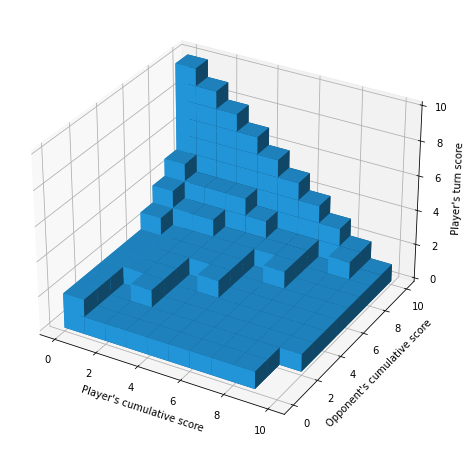

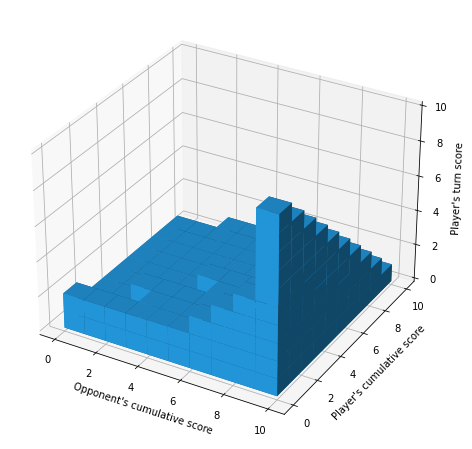

In [8]:
throw_swap = np.swapaxes(throw, 0, 1)

ax1 = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
colors = np.full(throw.shape, fill_value='#27a8f5', dtype=object)
ax1.voxels(throw, facecolors=colors)
ax1.set(xlabel='Player\'s cumulative score', ylabel='Opponent\'s cumulative score', zlabel='Player\'s turn score')

ax2 = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
colors = np.full(throw_swap.shape, fill_value='#27a8f5', dtype=object)
ax2.voxels(throw_swap, facecolors=colors)
ax2.set(xlabel='Opponent\'s cumulative score', ylabel='Player\'s cumulative score', zlabel='Player\'s turn score')

plt.show()